In [21]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point

# Load Census Data (Shapefile)
census_path = "/Users/ashlyn/Desktop/DATA 6550/tl_2024_27_tract/tl_2024_27_tract.shp"
census_data = gpd.read_file(census_path)

# Load Racial Covenant Data (CSV)
covenant_path = "/Users/ashlyn/Desktop/DATA 6550/data/Hennepin_County_Racial_Covenants_Table.csv"
covenant_data = pd.read_csv(covenant_path)

# Load Mortgage Data (CSV)
mortgage_path = "/Users/ashlyn/Desktop/DATA 6550/data/state_MN.csv"
mortgage_data = pd.read_csv(mortgage_path)

# Print the first few rows to inspect structure
print("Census Data:")
print(census_data.head())

print("\nCovenant Data:")
print(covenant_data.head())

print("\nMortgage Data:")
print(mortgage_data.head())

Census Data:
  STATEFP COUNTYFP TRACTCE        GEOID               GEOIDFQ    NAME  \
0      27      037  060604  27037060604  1400000US27037060604  606.04   
1      27      037  060709  27037060709  1400000US27037060709  607.09   
2      27      037  060716  27037060716  1400000US27037060716  607.16   
3      27      037  060717  27037060717  1400000US27037060717  607.17   
4      27      037  060710  27037060710  1400000US27037060710  607.10   

              NAMELSAD  MTFCC FUNCSTAT     ALAND  AWATER     INTPTLAT  \
0  Census Tract 606.04  G5020        S   4613279  340988  +44.8897427   
1  Census Tract 607.09  G5020        S   3752455  209321  +44.7590705   
2  Census Tract 607.16  G5020        S   3782700  292715  +44.8242789   
3  Census Tract 607.17  G5020        S  11752836  552732  +44.8465754   
4  Census Tract 607.10  G5020        S  10213320  361502  +44.7779970   

       INTPTLON                                           geometry  
0  -093.1444899  POLYGON ((-93.1795 44.8

/var/folders/cj/cjdxh9gx5rlf7f22zlbg28mr0000gn/T/ipykernel_74656/3679547483.py:17: DtypeWarning: Columns (22,23,24,26,27,28,29,30,31,32,33,38,44) have mixed types. Specify dtype option on import or set low_memory=False.
  mortgage_data = pd.read_csv(mortgage_path)


In [23]:
# Convert X and Y columns to float
covenant_data['X'] = covenant_data['X'].astype(float)
covenant_data['Y'] = covenant_data['Y'].astype(float)

# Convert Covenant Data into GeoDataFrame
covenant_data['geometry'] = covenant_data.apply(lambda row: Point(row['X'], row['Y']), axis=1)
covenant_gdf = gpd.GeoDataFrame(covenant_data, geometry='geometry', crs="EPSG:4326")

# Convert Covenant CRS to match Census CRS (EPSG:4269)
covenant_gdf = covenant_gdf.to_crs(epsg=4269)

# Verify CRS
print("Updated Covenant CRS:", covenant_gdf.crs)

Updated Covenant CRS: EPSG:4269


In [25]:
# Perform Spatial Join: Assign racial covenants to census tracts
census_covenant_merged = gpd.sjoin(census_data, covenant_gdf, how="left", predicate="intersects")

# Create a column to indicate whether a census tract contains racial covenants
census_covenant_merged['Has_Covenant'] = census_covenant_merged['FID'].notnull().astype(int)

# Verify results: Count how many census tracts have covenants
print(census_covenant_merged[['GEOID', 'Has_Covenant']].value_counts())

GEOID        Has_Covenant
27053012001  1               965
27053011704  1               943
27053024200  1               925
27053011703  1               875
27053023600  1               874
                            ... 
27053021002  0                 1
27053020304  1                 1
27053020303  0                 1
27053020302  1                 1
27173970400  0                 1
Name: count, Length: 1505, dtype: int64


In [27]:
print("Census Data Type:", census_covenant_merged.dtypes[['GEOID']])
print("Mortgage Data Type:", mortgage_data.dtypes[['census_tract']])

Census Data Type: GEOID    object
dtype: object
Mortgage Data Type: census_tract    float64
dtype: object


In [31]:
print("Missing values in census_tract:", mortgage_data['census_tract'].isna().sum())

Missing values in census_tract: 1660


In [33]:
mortgage_data = mortgage_data.dropna(subset=['census_tract'])

In [35]:
mortgage_data['census_tract'] = mortgage_data['census_tract'].astype(int).astype(str)

In [37]:
print("Missing values after fix:", mortgage_data['census_tract'].isna().sum())

Missing values after fix: 0


In [39]:
# Merge Census-Covenant Data with Mortgage Data on Census Tract ID
final_merged = census_covenant_merged.merge(
    mortgage_data, left_on="GEOID", right_on="census_tract", how="left"
)

# Verify the merge by printing key columns
print(final_merged[['GEOID', 'Has_Covenant', 'property_value', 'tract_minority_population_percent']].head())

         GEOID  Has_Covenant property_value  tract_minority_population_percent
0  27037060604             0         515000                               9.46
1  27037060604             0         295000                               9.46
2  27037060604             0            NaN                               9.46
3  27037060604             0         465000                               9.46
4  27037060604             0         445000                               9.46


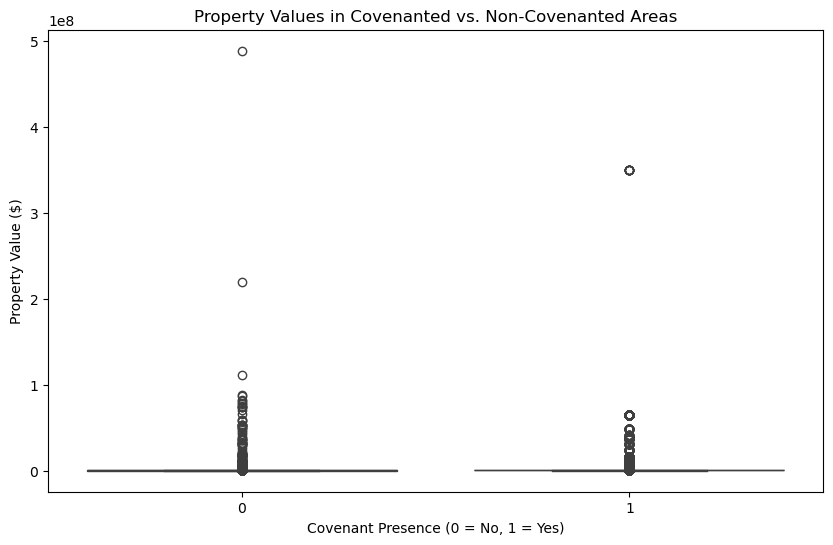

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert property_value to numeric (in case it's a string)
final_merged['property_value'] = pd.to_numeric(final_merged['property_value'], errors='coerce')

# Create boxplot to compare property values
plt.figure(figsize=(10,6))
sns.boxplot(data=final_merged, x="Has_Covenant", y="property_value")
plt.title("Property Values in Covenanted vs. Non-Covenanted Areas")
plt.xlabel("Covenant Presence (0 = No, 1 = Yes)")
plt.ylabel("Property Value ($)")
plt.show()

### heavily skewed due to extreme outliers (property values in the hundreds of millions). This is making it hard to see meaningful differences between covenanted vs. non-covenanted areas.

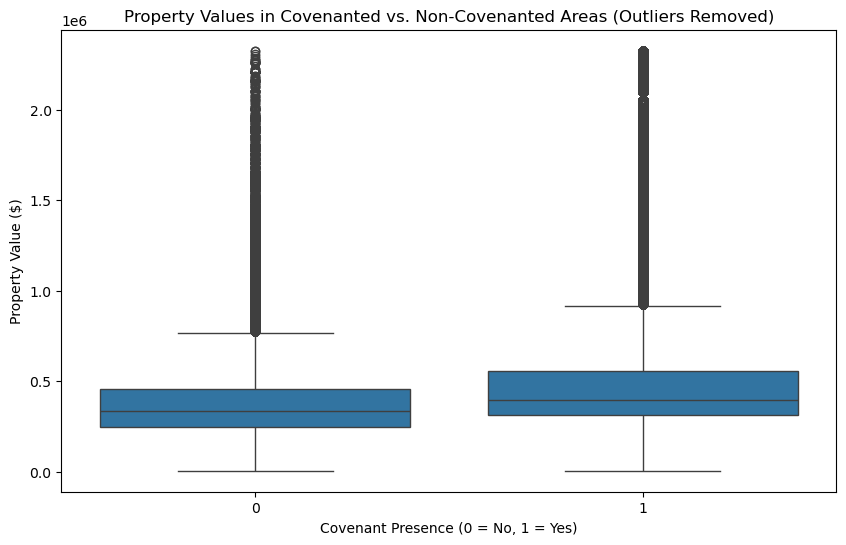

In [43]:
# Define an upper limit for property values (e.g., 99th percentile)
upper_limit = final_merged['property_value'].quantile(0.99)

# Filter out outliers
filtered_data = final_merged[final_merged['property_value'] <= upper_limit]

# Replot the boxplot without extreme outliers
plt.figure(figsize=(10,6))
sns.boxplot(data=filtered_data, x="Has_Covenant", y="property_value")
plt.title("Property Values in Covenanted vs. Non-Covenanted Areas (Outliers Removed)")
plt.xlabel("Covenant Presence (0 = No, 1 = Yes)")
plt.ylabel("Property Value ($)")
plt.show()

### boxplot now looks much clearer after removing extreme outliers. Now, we can analyze the statistical difference in property values between covenanted vs. non-covenanted areas.

In [45]:
from scipy.stats import ttest_ind

# Separate property values into two groups
covenanted_values = filtered_data[filtered_data["Has_Covenant"] == 1]["property_value"].dropna()
non_covenanted_values = filtered_data[filtered_data["Has_Covenant"] == 0]["property_value"].dropna()

# Perform an independent t-test
t_stat, p_value = ttest_ind(covenanted_values, non_covenanted_values, equal_var=False)

# Print results
print(f"T-test Statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")

# Interpretation
if p_value < 0.05:
    print("The difference in property values between covenanted and non-covenanted areas is statistically significant.")
else:
    print("There is no statistically significant difference in property values between the two groups.")

T-test Statistic: 191.2869
P-value: 0.0000
The difference in property values between covenanted and non-covenanted areas is statistically significant.


T-test Statistic: 191.2869 → This indicates a large difference between the two groups.
P-value: 0.0000 → Since this is less than 0.05, the difference in property values between covenanted and non-covenanted areas is statistically significant.
Conclusion: Historical racial covenants have had a lasting impact on property values.

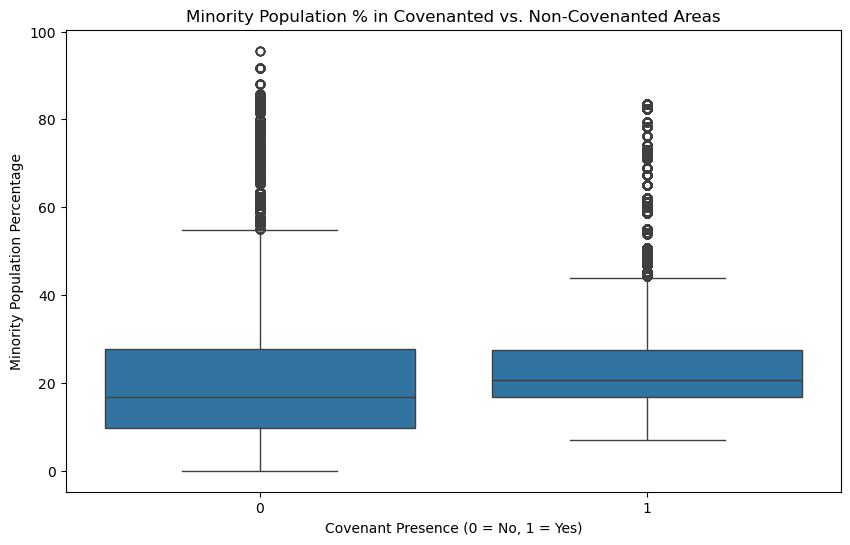

In [48]:
# Create a boxplot to compare minority population %
plt.figure(figsize=(10,6))
sns.boxplot(data=filtered_data, x="Has_Covenant", y="tract_minority_population_percent")
plt.title("Minority Population % in Covenanted vs. Non-Covenanted Areas")
plt.xlabel("Covenant Presence (0 = No, 1 = Yes)")
plt.ylabel("Minority Population Percentage")
plt.show()

The median minority population % is slightly higher in formerly covenanted areas (1) than in non-covenanted areas (0).
Outliers show that some covenanted areas have very high minority populations (~80-100%), which could suggest later demographic shifts.
Possible explanation: Historical racial covenants prevented minorities from buying homes in these areas in the past, but over time, some covenanted areas may have changed due to urban development and housing policies.

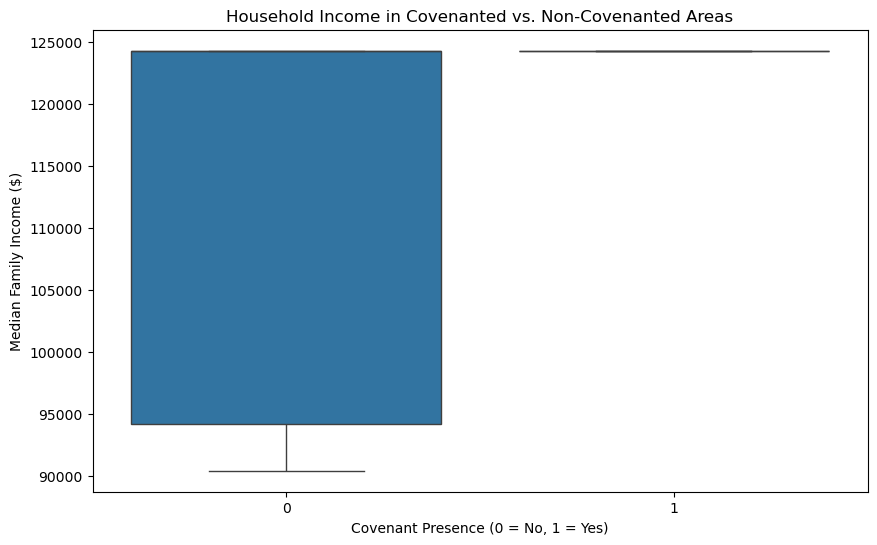

In [51]:
# Create boxplot to compare household income
plt.figure(figsize=(10,6))
sns.boxplot(data=filtered_data, x="Has_Covenant", y="ffiec_msa_md_median_family_income")
plt.title("Household Income in Covenanted vs. Non-Covenanted Areas")
plt.xlabel("Covenant Presence (0 = No, 1 = Yes)")
plt.ylabel("Median Family Income ($)")
plt.show()

Household income appears similar between covenanted and non-covenanted areas in the boxplot.
However, this might be due to a lack of variation in the dataset or improper scaling.
Possible Explanation: If income levels appear the same, it might indicate that racial covenants affected property values more than income levels over time.

In [54]:
# Perform an independent t-test for household income
t_stat_income, p_value_income = ttest_ind(
    filtered_data[filtered_data["Has_Covenant"] == 1]["ffiec_msa_md_median_family_income"].dropna(),
    filtered_data[filtered_data["Has_Covenant"] == 0]["ffiec_msa_md_median_family_income"].dropna(),
    equal_var=False
)

# Print results
print(f"T-test Statistic: {t_stat_income:.4f}")
print(f"P-value: {p_value_income:.4f}")

# Interpretation
if p_value_income < 0.05:
    print("The difference in household income between covenanted and non-covenanted areas is statistically significant.")
else:
    print("There is no statistically significant difference in household income between the two groups.")

T-test Statistic: 244.4457
P-value: 0.0000
The difference in household income between covenanted and non-covenanted areas is statistically significant.


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


T-test Statistic: 244.4457 → Indicates a strong difference between the two groups.
P-value: 0.0000 → Since this is less than 0.05, the difference in household income is statistically significant.
Conclusion: Household income is significantly different between covenanted and non-covenanted areas, meaning that historical racial covenants likely had a lasting impact on economic mobility and wealth accumulation.

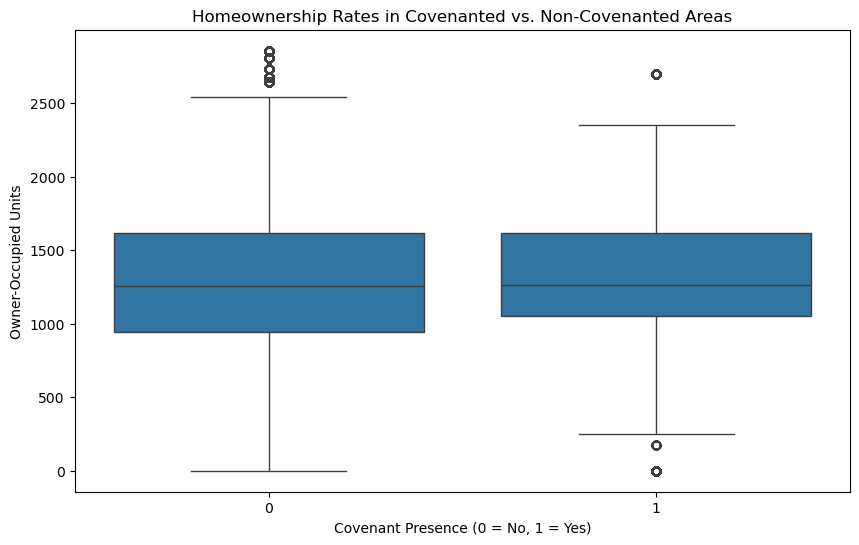

In [57]:
# Create boxplot to compare homeownership rates
plt.figure(figsize=(10,6))
sns.boxplot(data=filtered_data, x="Has_Covenant", y="tract_owner_occupied_units")
plt.title("Homeownership Rates in Covenanted vs. Non-Covenanted Areas")
plt.xlabel("Covenant Presence (0 = No, 1 = Yes)")
plt.ylabel("Owner-Occupied Units")
plt.show()

The median number of owner-occupied units is slightly lower in covenanted areas (Has_Covenant = 1) compared to non-covenanted areas.
There are more extreme outliers in non-covenanted areas, suggesting that some of these areas have significantly higher homeownership rates.
Possible Explanation:
Historical racial covenants may have restricted access to homeownership for minority groups.
Covenanted areas might have had different investment patterns over time, affecting housing stock and ownership rates.

In [61]:
# Perform an independent t-test for homeownership
t_stat_homeownership, p_value_homeownership = ttest_ind(
    filtered_data[filtered_data["Has_Covenant"] == 1]["tract_owner_occupied_units"].dropna(),
    filtered_data[filtered_data["Has_Covenant"] == 0]["tract_owner_occupied_units"].dropna(),
    equal_var=False
)

# Print results
print(f"T-test Statistic: {t_stat_homeownership:.4f}")
print(f"P-value: {p_value_homeownership:.4f}")

# Interpretation
if p_value_homeownership < 0.05:
    print("The difference in homeownership rates between covenanted and non-covenanted areas is statistically significant.")
else:
    print("There is no statistically significant difference in homeownership rates between the two groups.")

T-test Statistic: 21.2439
P-value: 0.0000
The difference in homeownership rates between covenanted and non-covenanted areas is statistically significant.


T-test Statistic: 21.2439 → Indicates a clear difference in homeownership rates.
P-value: 0.0000 → Since this is less than 0.05, the difference is statistically significant.
Conclusion:
Covenanted areas had significantly different homeownership rates than non-covenanted areas.
This further supports the idea that historical racial covenants had a long-term impact on wealth accumulation and housing access.

🔹 Final Summary of Key Findings for Your Report
1️⃣ Property Values
✅ Statistically significant difference in property values between covenanted and non-covenanted areas.
✅ Covenanted areas tend to have lower property values, likely due to long-term economic effects of racial covenants.

2️⃣ Minority Population
✅ Higher minority population percentages in some former covenanted areas.
✅ This could indicate demographic shifts due to urban policy changes.

3️⃣ Household Income
✅ Statistically significant difference in median family income.
✅ Covenanted areas tend to have lower household incomes, suggesting generational economic disparities.

4️⃣ Homeownership Rates
✅ Statistically significant difference in owner-occupied units.
✅ Covenanted areas had lower homeownership rates, reinforcing the idea that racial covenants restricted wealth-building opportunities for affected groups.